# The wPCC VCT model check

In [15]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import SemiempiricalRudderSystem
from vessel_manoeuvring_models.models.wind_force import WindForceSystem
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem, EquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models import prime_system
from vessel_manoeuvring_models.models.modular_simulator import subs_simpler
import statsmodels.api as sm
from wPCC_pipeline.pipelines.vct_data.nodes import vct_scaling
from vct.bokeh_plotting import create_tab

import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

Loading BokehJS ...

In [3]:
%reload_kedro
ship='wPCC'
df_VCT = catalog.load(f"{ship}.df_VCT")
ship_data = catalog.load(f"{ship}.ship_data")
df_VCT = vct_scaling(data=df_VCT, ship_data=ship_data)
df_VCT['U'] = df_VCT['V']
thrust_keys = catalog.load(f"params:wPCC.thrust_keys")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
model_loaders = catalog.load(f"{ship}.models")

df_VCT.sort_values(by=['test type','V','delta','v'], inplace=True)

[07/11/23 10:25:29] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=20137;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=776727;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/11/23 10:25:38] INFO     Kedro project phd                                                      ]8;id=919190;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=981947;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=706453;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=577925;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=557822;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=361108;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=527202;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=250079;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=299227;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=874198;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.thrust_keys' (MemoryDataSet)...     ]8;id=340548;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=604877;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=423276;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=822161;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=660696;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=109227;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
model_loaders.keys()

dict_keys(['MDL_modular', 'MDL_modular_propeller_rudder', 'MDL_modular_propeller_rudder_wind', 'SLIC_propeller', 'VCT_MDL_resistance', 'VCT_MDL_resistance_wind', 'modular', 'semiempirical_rudder', 'vct', 'vmm_abkowitz_diminished', 'wpcc.updated.vmm_martins_simple.joined.model'])

In [5]:
model_vct = model_loaders['vct']()

In [6]:
states = df_VCT[['u', 'v', 'r']]
control = df_VCT[['delta','rev']]
hull = model_vct.subsystems['hull']
df_predicted_hull_forces = pd.DataFrame(hull.calculate_forces(states_dict=states, control=control, calculation={}))

In [7]:
df_prediction = df_VCT.copy()
df_prediction['model_name'] = 'Prediction'
df_prediction['fx_hull'] = df_predicted_hull_forces['X_H']
df_prediction['fy_hull'] = df_predicted_hull_forces['Y_H']
df_prediction['mz_hull'] = df_predicted_hull_forces['N_H']
results = pd.concat((df_VCT, df_prediction), axis=0)

In [8]:
create_tab(df_VCT=results, ys=['fx_hull','fy_hull','mz_hull'])

Tabs(id='6320', ...)

## Simulation

In [9]:
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")

id = 22773
data = time_series_smooth[f'wpcc.updated.{id}.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)

[07/11/23 10:25:44] INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=67325;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=127964;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

In [11]:
model_vct_MDL_resistance = model_loaders['VCT_MDL_resistance']()

In [12]:
result = model_vct.simulate(data)
result2 = model_vct_MDL_resistance.simulate(data)

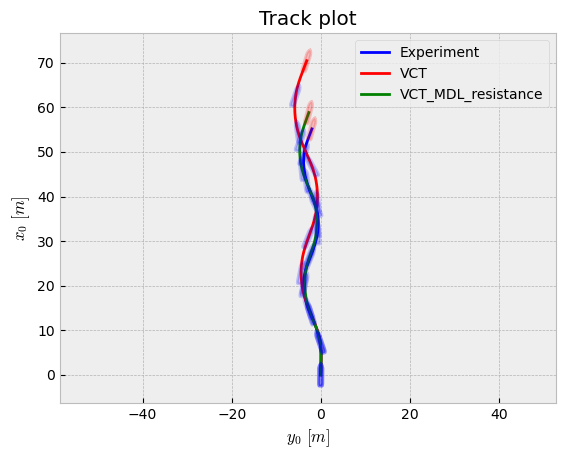

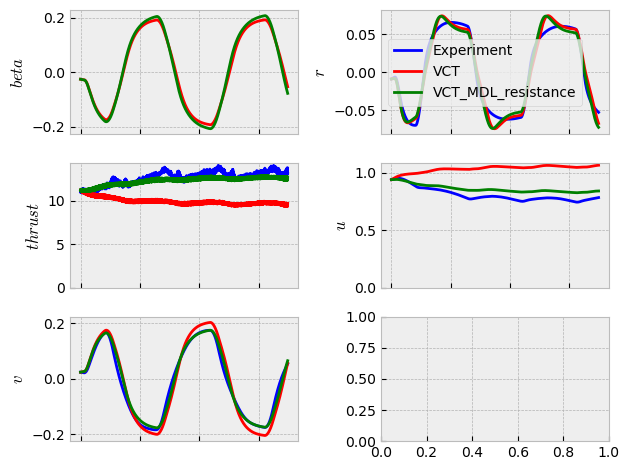

In [14]:
dataframes = {
              'Experiment':data,
              'VCT':result,
              'VCT_MDL_resistance':result2,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','beta','thrust']);